# Featurize processed data

In [1]:
repo_path = "/Users/johnzhou/research/decision-making"

## Import packages

In [2]:
import sys
sys.path.append(repo_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from sklearn.cluster import KMeans
import torch

from src.data.experiment_data import ExperimentData
from src.features.build_features import normalize_features, remove_invalid_fits
from src.models.sigmoidnet import SigmoidNet
from src.models.train import train
from src.visualization.plot_replications import plot_fitted_block
from src.features.fit_curves import epsilon_sigmoid

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
expt_name = "generate_ssm_histogram"
bigboy = ExperimentData(expt_name, repo_path)
boundary = list(bigboy.agent_labels == 1).index(True)
# valid_idxs = bigboy.get_valid_idxs(boundary=boundary)
# invalid_idxs = np.arange(bigboy.agent_labels.size)
# invalid_idxs = np.delete(invalid_idxs, valid_idxs)
# bigboy.build_modeling_feats(include_feff=False, include_block=False)
# bigboy.build_modeling_labels()

[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.01       0.80473684]


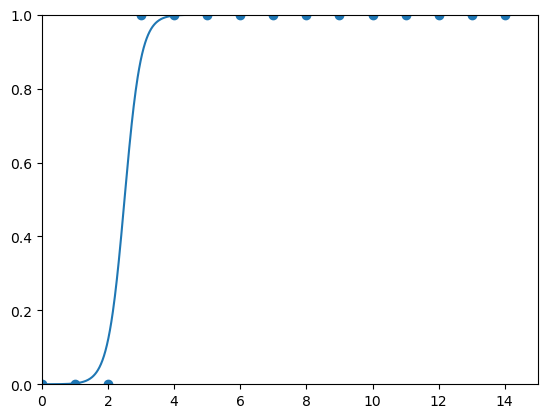

In [34]:
mf = np.argwhere(np.all(bigboy.choice_blocks[:boundary] == np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), axis=1)).flatten()
mb = np.argwhere(np.all(bigboy.choice_blocks[boundary:] == np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), axis=1)).flatten()
mf_idx = mf[0]
mb_idx = mb[0] + boundary

print(bigboy.choice_blocks[mb_idx])
print(bigboy.parameter_labels[mb_idx])

plt.figure()

choice_block = np.expand_dims(bigboy.choice_blocks[mb_idx], axis=0)
x_bounds = (0, choice_block.shape[1])

curve_func = epsilon_sigmoid
params = bigboy.sigmoid_parameters[mf_idx]

plt.plot(np.linspace(*x_bounds, num=1000),
         curve_func(np.linspace(*x_bounds, num=1000), *params))
plt.scatter(range(choice_block.size), list(choice_block))
plt.xlim(x_bounds)
plt.ylim([0, 1])
# plt.legend()
plt.savefig(f'/Users/johnzhou/Desktop/sample_mb_curve.eps', format='eps')



In [7]:
config = OmegaConf.create({
    "name": expt_name,
    "random_seed": 4995,
    "model": {
        "in_features": 3,
        "linear_layers": [32, 8, 4],
        "use_batch_norm": False
    },
    "learning_rate": 1e-4,
    "data": {
        "feature_path": f"{bigboy.data_path}/modeling_features.npy",
        "label_path": f"{bigboy.data_path}/modeling_labels.npy",
        "train_proportion": 0.8,
        "train_batch_size": 128,
        "val_batch_size": 128
    },
    "trainer": {
        "gpus": 0,
        "max_epochs": 1000
    },

})

OmegaConf.save(config=config, f=f"{repo_path}/configs/model_configs/sigmoidnet_train.yaml")

In [8]:
%reload_ext tensorboard
%tensorboard --logdir=$bigboy.data_path/lightning_logs

In [9]:
system, trainer = train(
    SigmoidNet,
    OmegaConf.to_container(config),
    experiment_dir=bigboy.data_path,
    checkpoint_name="model")

Global seed set to 4995


LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/johnzhou/research/decision-making/data/processed/generate_ssm_histogram/lightning_logs

  | Name  | Type           | Params
-----------------------------------------
0 | loss  | SupConLoss     | 0     
1 | model | LinearEmbedder | 438   
-----------------------------------------
438       Trainable params
0         Non-trainable params
438       Total params
0.002     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                 | 0/2 [00:00<?, ?it/s]

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████████████▉    | 6240/7813 [00:26<00:06, 237.66it/s, loss=4.5, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███| 7813/7813 [00:31<00:00, 251.92it/s, loss=4.49, v_num=0, val_loss=4.500]
Epoch 1:  80%|▊| 6240/7813 [00:34<00:08, 183.23it/s, loss=4.49, v_num=0, val_loss=4.500, t
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                | 0/1563 [00:00<?, ?it/s]
Epoch 1:  80%|▊| 6260/7813 [00:34<00:08, 183.33it/s, loss=4.49, v_num=0, val_loss=4.500, t
Epoch 1:  80%|▊| 6280/7813 [00:34<00:08, 183.28it/s, loss=4.49, v_num=0, val_loss=4.500, t
Epoch 1:  81%|▊| 6300/7813 [00:34<00:08, 183.22it/s, loss=4.49, v_num=0, val_loss=4.500, t
Epoch 1:  81%|▊| 6320/7813 [00:34<00:08, 183.44it/s, loss=4.49, v_num=0, val_loss=4.500, t
Epoch 1:  81%|▊| 6340/7813 [00:34<00:08, 183.71it/s, loss=4.49, v_num=0, val_loss=4.500, t
Epoch 1:  81%|▊| 6360/7813 [00:34<00:07, 183.93it/s, loss=4.49, v_num=0, val_loss=4.500, t
Epoch 1:  82%|▊| 6380/7813 [

Epoch 2:  82%|▊| 6380/7813 [00:36<00:08, 176.48it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  82%|▊| 6400/7813 [00:36<00:07, 176.79it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  82%|▊| 6420/7813 [00:36<00:07, 177.07it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  82%|▊| 6440/7813 [00:36<00:07, 177.33it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  83%|▊| 6460/7813 [00:36<00:07, 177.60it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  83%|▊| 6480/7813 [00:36<00:07, 177.89it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  83%|▊| 6500/7813 [00:36<00:07, 178.15it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  83%|▊| 6520/7813 [00:36<00:07, 178.41it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  84%|▊| 6540/7813 [00:36<00:07, 178.69it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  84%|▊| 6560/7813 [00:36<00:07, 178.98it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 2:  84%|▊| 6580/7813 [00:36<00:06, 179.26it/s, loss=4.48, v_num=0, val_loss=4.490, t

Epoch 4:  84%|▊| 6540/7813 [00:31<00:06, 204.66it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  84%|▊| 6560/7813 [00:32<00:06, 205.00it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  84%|▊| 6580/7813 [00:32<00:06, 205.35it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  84%|▊| 6600/7813 [00:32<00:05, 205.73it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  85%|▊| 6620/7813 [00:32<00:05, 206.10it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  85%|▊| 6640/7813 [00:32<00:05, 206.47it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  85%|▊| 6660/7813 [00:32<00:05, 206.82it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  85%|▊| 6680/7813 [00:32<00:05, 207.12it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  86%|▊| 6700/7813 [00:32<00:05, 207.40it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  86%|▊| 6720/7813 [00:32<00:05, 207.66it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 4:  86%|▊| 6740/7813 [00:32<00:05, 207.98it/s, loss=4.48, v_num=0, val_loss=4.490, t

Epoch 6:  86%|▊| 6700/7813 [00:31<00:05, 209.87it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  86%|▊| 6720/7813 [00:31<00:05, 210.23it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  86%|▊| 6740/7813 [00:32<00:05, 210.59it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  87%|▊| 6760/7813 [00:32<00:04, 210.93it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  87%|▊| 6780/7813 [00:32<00:04, 211.28it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  87%|▊| 6800/7813 [00:32<00:04, 211.60it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  87%|▊| 6820/7813 [00:32<00:04, 211.93it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  88%|▉| 6840/7813 [00:32<00:04, 212.25it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  88%|▉| 6860/7813 [00:32<00:04, 212.58it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  88%|▉| 6880/7813 [00:32<00:04, 212.90it/s, loss=4.48, v_num=0, val_loss=4.490, t
Epoch 6:  88%|▉| 6900/7813 [00:32<00:04, 213.23it/s, loss=4.48, v_num=0, val_loss=4.490, t

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [10]:
X_fname = f"{bigboy.data_path}/modeling_features.npy"
model_fname = f"{bigboy.data_path}/models/model-v1.ckpt"
system = SigmoidNet(config)

model = system.load_from_checkpoint(model_fname)

LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)
LinearEmbedder(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.05)
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.05)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.05)
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


In [196]:
import os

from src.data.experiments import RealExperiment
from src.data.environments import DynamicForagingTask
from src.features.fit_curves import get_sigmoid_feats
from src.features.losses import mse_loss
from src.utils import build_config, blockify, normalize_choice_block_side, truncate_blocks

trial_bounds = (15, 25)
sig_params = []

directory = "/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging"
filenames = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
    expt = RealExperiment(filename=f, task_type=DynamicForagingTask)
    actions = expt.action_history
    rewards = expt.reward_history
    blocked_actions = blockify(expt.blocks, actions)
    blocks = expt.blocks
    normalized_actions = [normalize_choice_block_side(blocked_actions[block_idx], side=blocks[block_idx][0])
                          for block_idx in range(len(blocks)) if blocks[block_idx][2] > 15]
    truncated_actions = truncate_blocks(normalized_actions, truncate_length=trial_bounds[0])
    for x in get_sigmoid_feats(truncated_actions, mse_loss):
        sig_params.append(x)
    

100%|████████████████████████████████████████████| 20/20 [00:00<00:00, 114.35it/s]


In [197]:
sig_params = np.array(sig_params)
real_embed = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(sig_params).float(), 1))).detach().numpy()


In [233]:
from sklearn.decomposition import PCA
pca_x = np.squeeze(bigboy.sigmoid_parameters[bigboy.get_valid_idxs(boundary=50000)])[48381:]
pca_x = normalize_features(pca_x)

mb_pca = PCA(n_components=2)
mb_pca.fit(pca_x)
X_embedded_mse = pca.transform(pca_x)
print(X_embedded_mse.shape)

48381
(50000, 2)


(50000, 2)


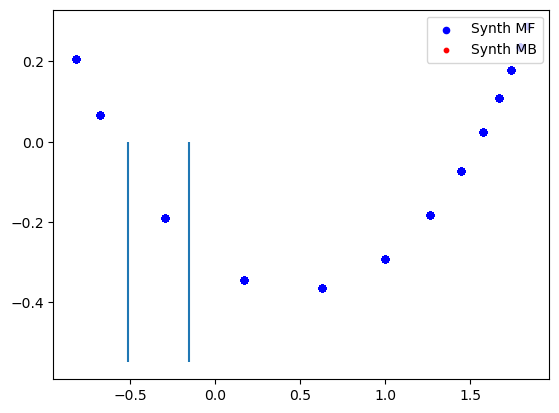

In [234]:
# X_embedded_mse = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(np.load(X_fname)).float(), 1))).detach().numpy()
print(X_embedded_mse.shape)

plt.figure()
mse_boundary = 50000

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=20)
mb = plt.scatter(X_embedded_mse[mse_boundary:, 0], X_embedded_mse[mse_boundary:, 1], color='red', s=10)
# real = plt.scatter(real_embed[:, 0], real_embed[:, 1], color='cyan', s=5)

plt.legend((mf, mb), ('Synth MF', 'Synth MB'), loc='upper right')

l_border = -0.51
r_border = -0.155

plt.vlines([l_border, r_border], -.55, -0)

plt.show()

In [199]:
dim = 0
print("% of MF that are over:", np.sum(X_embedded_mse[:mse_boundary, dim] > border) / X_embedded_mse[:mse_boundary, dim].size)
print("% of MB that are under:", np.sum(X_embedded_mse[mse_boundary:, dim] < border) / X_embedded_mse[mse_boundary:, dim].size)

print("% of over that are MF:",np.sum(X_embedded_mse[:mse_boundary, dim] > border) / np.sum(X_embedded_mse[:, dim] > border))
print("% of under that are MB:",np.sum(X_embedded_mse[mse_boundary:, dim] < border) / np.sum(X_embedded_mse[:, dim] < border))



% of MF that are over: 0.7924693313163307
% of MB that are under: 0.9108677818596854
% of over that are MF: 0.8702660609993511
% of under that are MB: 0.853314621758888


In [210]:
invalid = np.arange(100000)
invalid = np.delete(invalid, bigboy.get_valid_idxs())
print(invalid.shape)

(1619,)


In [211]:
embed_all = torch.squeeze(model(torch.unsqueeze(torch.from_numpy(bigboy.sigmoid_parameters).float(), 1))).detach().numpy()
idxs = np.argwhere((embed_all[:, dim] > l_border) & (embed_all[:, dim] < r_border))
boola = np.array([(i not in invalid) for i in list(idxs)])
print(boola.shape)
idxs = idxs[boola]


(62867,)


In [11]:
plt.hist(bigboy.parameter_labels[mf_cluster, 1])

NameError: name 'mf_cluster' is not defined

(500, 3)


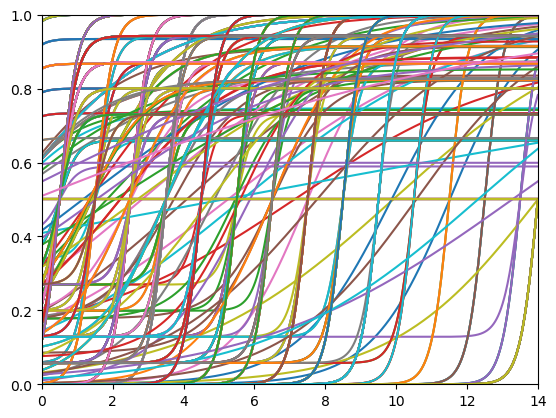

In [17]:
idxs = np.random.choice(np.arange(0, boundary), size=500, replace=True, p=None)

bigboy.visualize_sigmoids(idxs)

500000
(1000000, 3)
(1000, 3)


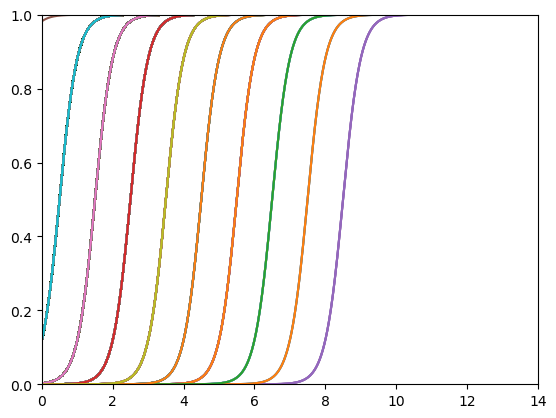

In [19]:
print(boundary)
print(bigboy.sigmoid_parameters.shape)
idxs = np.random.choice(np.arange(boundary, 1000000), size=1000, replace=True, p=None)

bigboy.visualize_sigmoids(idxs)

(50000, 3)


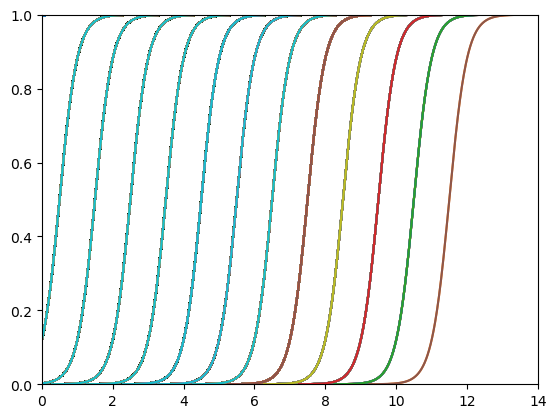

In [101]:
bigboy.visualize_sigmoids()

(array([2.0856e+04, 4.9000e+01, 1.3000e+01, 1.7000e+01, 4.0000e+00,
        9.4820e+03, 9.0000e+01, 5.9800e+02, 1.2560e+03, 1.9400e+02,
        6.1000e+01, 1.0600e+02, 6.2760e+03, 3.1000e+01, 3.0300e+02,
        6.2000e+01, 1.9800e+02, 8.3900e+02, 9.0000e+00, 3.3020e+03,
        1.6000e+01, 5.4700e+02, 3.5000e+01, 3.3000e+01, 1.2000e+01,
        1.8500e+02, 1.9940e+03, 3.0000e+00, 4.5100e+02, 5.0000e+00,
        4.0000e+00, 2.4000e+01, 2.8000e+01, 2.2500e+02, 6.6400e+02,
        2.6700e+02, 1.0000e+00, 2.0000e+00, 3.0000e+00, 5.0000e+00,
        9.0000e+00, 2.8300e+02, 1.1700e+02, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 4.0000e+00, 7.0000e+00, 1.4000e+01, 1.3150e+03]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

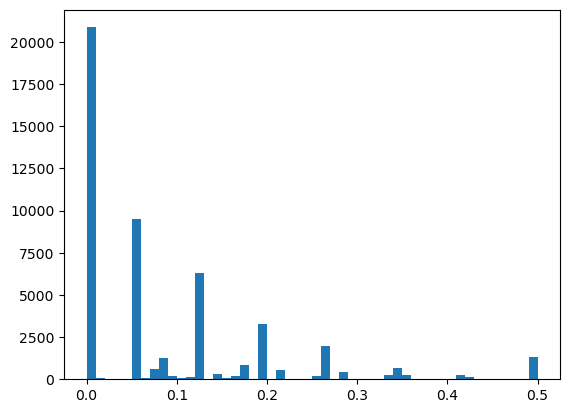

In [243]:
plt.hist(bigboy.sigmoid_parameters[:50000, 0], bins=50)

(array([9.000e+01, 2.940e+02, 4.480e+02, 7.520e+02, 4.930e+02, 7.310e+02,
        5.500e+02, 6.790e+02, 2.150e+02, 6.410e+02, 4.910e+02, 1.493e+03,
        5.100e+02, 6.760e+02, 2.790e+02, 2.160e+02, 2.060e+02, 1.100e+01,
        1.200e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.960e+02,
        1.760e+02, 1.290e+02, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.991e+04]),
 array([0.01378116, 0.09350553, 0.17322991, 0.25295429, 0.33267866,
        0.41240304, 0.49212742, 0.57185179, 0.65157617, 0.73130055,
        0.81102493, 0.8907493 , 0.97047368, 1.05019806, 1.12992243,
        1.20964681, 1.28937119, 1.36909556, 1.44881994, 1.52854432,
        1.60826869, 1.68799307, 1.76771745, 1.84744182, 1.9271662 ,
        2.00689058, 2.08661496, 2.16

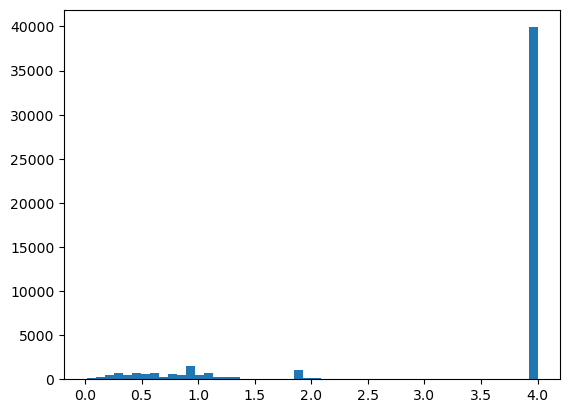

In [244]:
plt.hist(bigboy.sigmoid_parameters[:50000, 1], bins=50)

(array([20140.,  5716.,  5372.,  6614.,  3534.,  3664.,  1271.,  1422.,
          390.,  1877.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

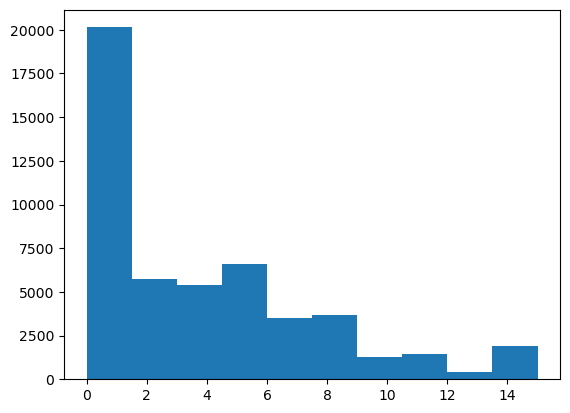

In [237]:
plt.hist(bigboy.sigmoid_parameters[:50000, 2])

(array([    0.,     0.,     0.,     0.,     0., 50000.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

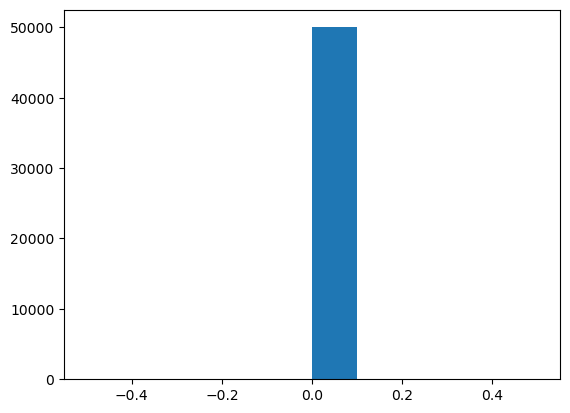

In [238]:
plt.hist(bigboy.sigmoid_parameters[50000:, 0])

(array([    0.,     0.,     0.,     0.,     0., 50000.,     0.,     0.,
            0.,     0.]),
 array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5]),
 <BarContainer object of 10 artists>)

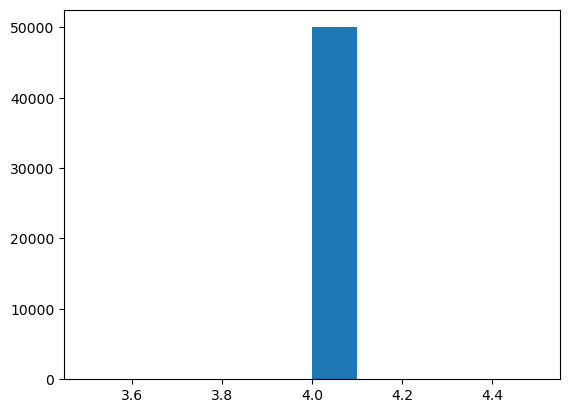

In [239]:
plt.hist(bigboy.sigmoid_parameters[50000:, 1])

(array([3.2873e+04, 1.0890e+04, 3.3660e+03, 1.9410e+03, 4.8000e+02,
        2.2300e+02, 1.1900e+02, 6.7000e+01, 2.9000e+01, 1.2000e+01]),
 array([ 0.  ,  1.15,  2.3 ,  3.45,  4.6 ,  5.75,  6.9 ,  8.05,  9.2 ,
        10.35, 11.5 ]),
 <BarContainer object of 10 artists>)

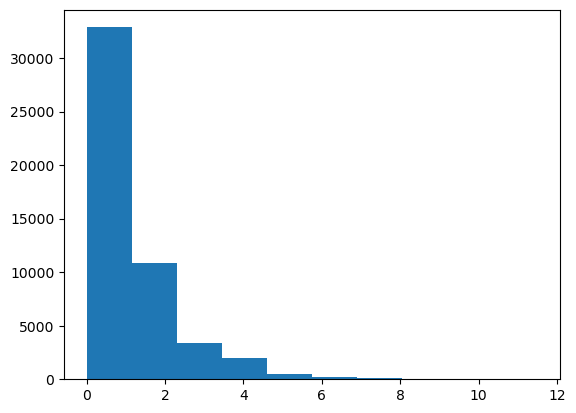

In [240]:
plt.hist(bigboy.sigmoid_parameters[50000:, 2])